In [2]:
from PIL import Image
from transformers import AutoProcessor, SiglipVisionModel, SiglipVisionConfig
import torch
from torch import nn
from torch.nn import functional as F
from dataclasses import dataclass
from torchvision import transforms
import matplotlib.pyplot as plt
import math

c:\anaconda\envs\VIT_Venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


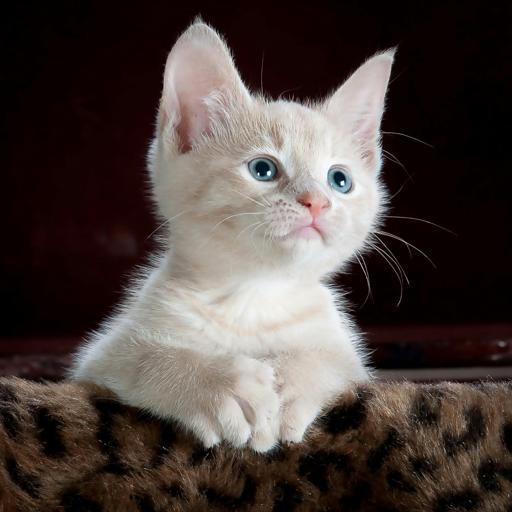

In [3]:
img = Image.open("image.jpeg")
img

In [4]:
processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224")
vision_model = SiglipVisionModel.from_pretrained("google/siglip-base-patch16-224", config=SiglipVisionConfig(vision_use_head=False))


In [5]:
vision_model

SiglipVisionModel(
  (vision_model): SiglipVisionTransformer(
    (embeddings): SiglipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
      (position_embedding): Embedding(196, 768)
    )
    (encoder): SiglipEncoder(
      (layers): ModuleList(
        (0-11): 12 x SiglipEncoderLayer(
          (self_attn): SiglipSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): SiglipMLP(
            (activation_fn): PytorchGELUTanh()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bi

In [6]:
def data_preprocess(image, image_size= 224):
    try:
        preprocess = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
        
        image_tensor = preprocess(image)
        
        #include batch dimension
        image_tensor = image_tensor.unsqueeze(0)
        return image_tensor
    
    except Exception as e:
        raise e
    

In [7]:
image_tensor = data_preprocess(img)

embd_dim = 768
patch_size = stride_size = 16
image_size = 224
number_of_patches = (image_size//patch_size)**2

with torch.no_grad():
    patch_embeddings = nn.Conv2d(in_channels=3, out_channels=embd_dim, kernel_size=patch_size, stride=stride_size)
    patches = patch_embeddings(image_tensor)
    
patches.shape , number_of_patches 

(torch.Size([1, 768, 14, 14]), 196)

In [8]:
positional_embeddings = nn.Embedding(number_of_patches, embd_dim)
positional_ids = torch.arange(number_of_patches).expand((1, -1))

positional_ids.shape, positional_embeddings

(torch.Size([1, 196]), Embedding(196, 768))

In [13]:
torch.arange(number_of_patches).expand((1, -1))

tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
          56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
          70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
          98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
         112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
         126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
         140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
         154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
         168, 169, 170, 171, 172, 173, 174, 175, 176

In [29]:
positional_embeddings(torch.tensor([[1,2,3], [3,4,5]])).shape

torch.Size([2, 3, 768])

In [11]:
patches.shape

torch.Size([1, 768, 14, 14])

In [30]:
patches.flatten(start_dim=2).shape

torch.Size([1, 768, 196])

In [14]:
positional_embeddings(positional_ids).shape, positional_embeddings

(torch.Size([1, 196, 768]), Embedding(196, 768))

In [15]:
# flatten
embeddings = patches.flatten(start_dim=2, end_dim=-1)
print(embeddings.shape)
embeddings = embeddings.transpose(1,2)
print(embeddings.shape)
embeddings = embeddings + positional_embeddings(positional_ids)

embeddings.shape

torch.Size([1, 768, 196])
torch.Size([1, 196, 768])


torch.Size([1, 196, 768])

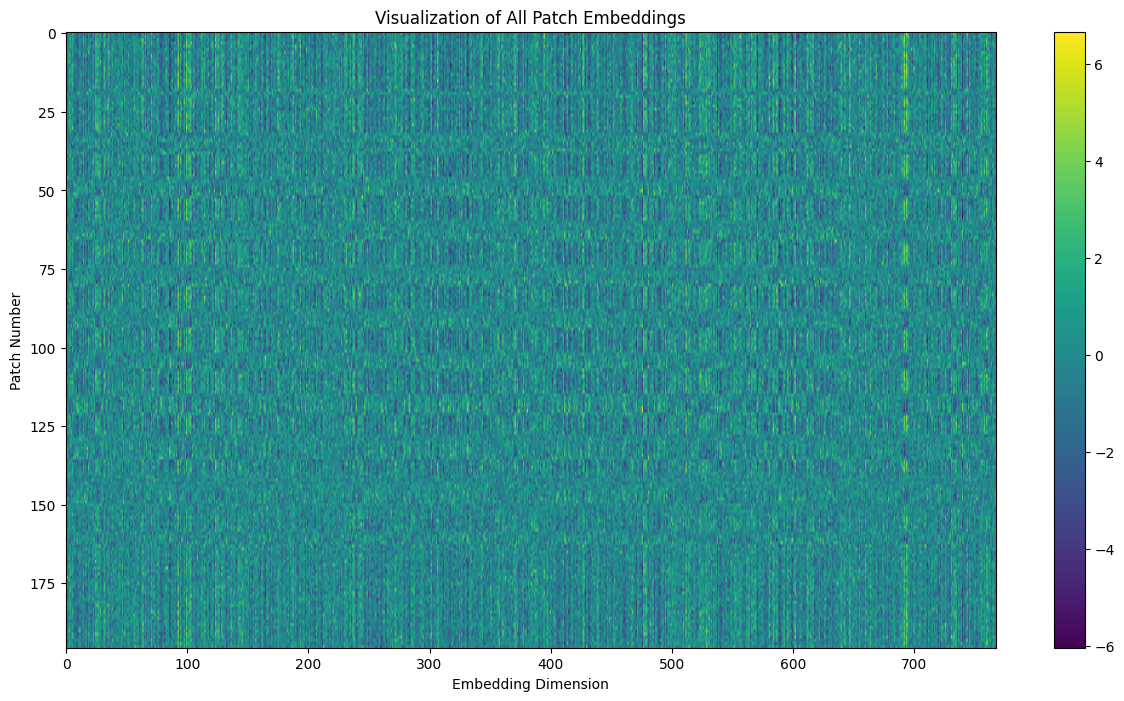

In [16]:
#visualize
emb_vis = embeddings[0].detach().numpy()
plt.figure(figsize=(15, 8))
plt.imshow(emb_vis, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Visualization of All Patch Embeddings')
plt.xlabel('Embedding Dimension')
plt.ylabel('Patch Number')
plt.show()

torch.Size([1, 3, 224, 224])
torch.Size([1, 196, 768])


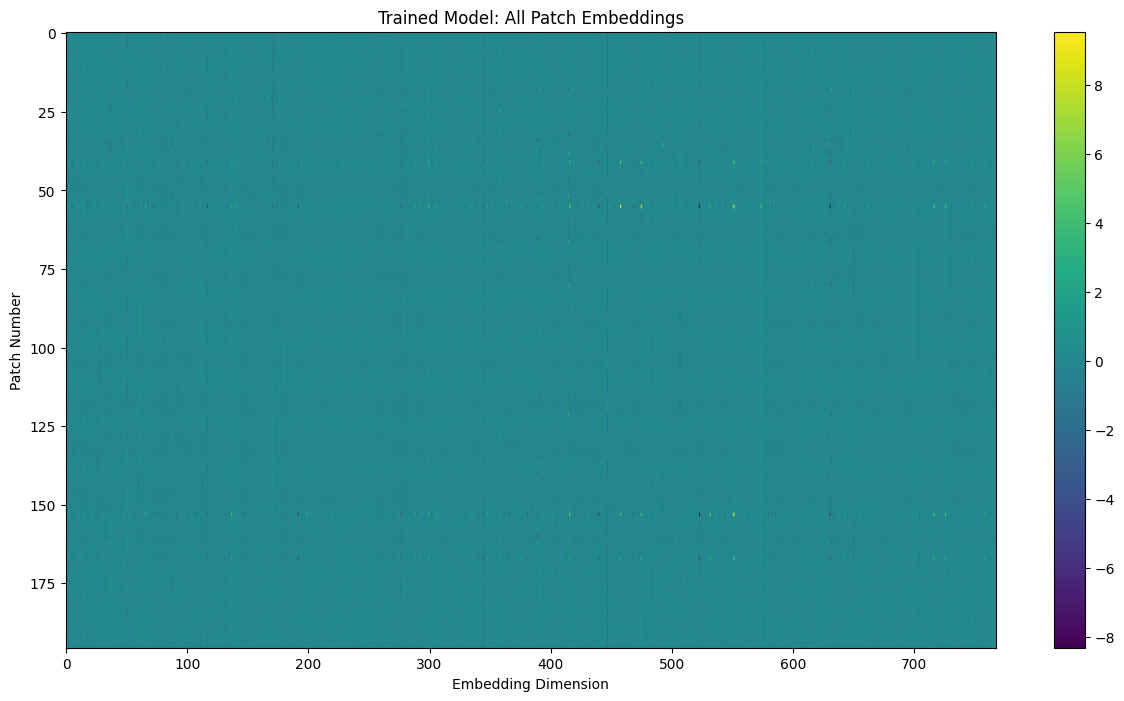

In [17]:
vision_model.eval()
inputs = processor(images=img, return_tensors="pt")

print(inputs.pixel_values.shape)

with torch.no_grad():
    patch_embeddings = vision_model.vision_model.embeddings(inputs.pixel_values)
    
print(patch_embeddings.shape)

patches_viz = patch_embeddings[0].detach().numpy()  # Shape: [196, 768]

plt.figure(figsize=(15, 8))
plt.imshow(patches_viz, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Trained Model: All Patch Embeddings')
plt.xlabel('Embedding Dimension')
plt.ylabel('Patch Number')
plt.show()

In [18]:
@dataclass
class Siglip_Vision_Config:
    num_channels: int = 3
    embd_dim: int = 768
    image_size:  int = 224
    patch_size: int = 16
    num_heads: int = 12
    hidden_size: int = 768
    dropout: float = 0.0
    intermediate_size : int = 3072
    layer_norm_eps : float = 1e-6

In [19]:
class SiglipVisionEmbeddings(nn.Module):
    def __init__(self, config: Siglip_Vision_Config):
        super().__init__()
        
        self.config = config
        self.num_channels = config.num_channels
        self.embd_dim = config.embd_dim
        self.image_size = config.image_size
        self.patch_size = config.patch_size
        
        self.patch_embedding = nn.Conv2d(
            in_channels=self.num_channels,
            out_channels=self.embd_dim,
            kernel_size=self.patch_size,
            stride=self.patch_size,
            padding="valid"
        )
        
        self.num_patches = (self.image_size // self.patch_size) ** 2
        self.num_positions = self.num_patches
        
        self.position_embedding = nn.Embedding(self.num_positions, self.embd_dim)
        
        self.register_buffer(
            "position_ids",
            torch.arange(self.num_positions).expand(1, -1),
            persistent=True
        )
        
    def forward(self, pixel_values:torch.FloatTensor) -> torch.Tensor:
        B,  C, H, W = pixel_values.shape
        
        patch_embeddings = self.patch_embedding(pixel_values)
        embeddings = patch_embeddings.flatten(start_dim=2, end_dim=-1)
        embeddings = embeddings.transpose(1,2)
        embeddings = embeddings + self.position_embedding(self.position_ids)
        return embeddings
        

In [20]:
embd = SiglipVisionEmbeddings(Siglip_Vision_Config())
embd

SiglipVisionEmbeddings(
  (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
  (position_embedding): Embedding(196, 768)
)

In [21]:
embd(image_tensor).shape

torch.Size([1, 196, 768])

### MHA

In [22]:
class Head(nn.Module):
    """
        single head of the multi-head attention
    """
    def __init__(self, n_in, head_size):
        super().__init__()
        
        self.head_size = head_size
        self.key = nn.Linear(n_in, head_size, bias=False)
        self.value = nn.Linear(n_in, head_size, bias=False)
        self.query = nn.Linear(n_in, head_size, bias=False)
        
    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        v = self.value(x)
        q = self.query(x)
        
        weight = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(self.head_size))
        weight = F.softmax(weight, dim=-1)
        out = weight @ v
        return out
        
        
class MultiHeadAttention():
    """
        Cncatenate each head's output
    """
    def __init__(self, n_head, n_in, head_size):
        super().__init__()
        self.head_size = head_size
        self.num_head = n_head
        self.heads = [Head(n_in, head_size) for _ in range(n_head)]
        self.proj = nn.Linear(n_in, n_in)
        
    def forward(self, x):
        out = [h(x) for h in self.heads]
        out = torch.concat(out, -1)
        out = self.proj(out)
        return out
    

### implement siglipAttention

In [23]:
class SiglipAttention(nn.Module):
    def __init__(self, config : Siglip_Vision_Config):
        super().__init__()
        
        self.config = config
        self.embd_dim = config.embd_dim
        self.num_heads = config.num_heads
        self.dropout = config.dropout
        
        self.k_proj = nn.Linear(self.embd_dim, self.embd_dim)
        self.q_proj = nn.Linear(self.embd_dim, self.embd_dim)
        self.v_proj = nn.Linear(self.embd_dim, self.embd_dim)
        self.out_proj = nn.Linear(self.embd_dim, self.embd_dim)
        
    def forward(self, hidden_states):
        B, T, C = hidden_states.shape
        
        q_states = self.q_proj(hidden_states)   # (B, T, 768)
        k_states = self.k_proj(hidden_states)
        v_states = self.v_proj(hidden_states)
        
        q_states = q_states.view(B, T, self.num_heads, C // self.num_heads).transpose(1,2)   # (B, T, 12, 64) -> transpose -> (B, 12,T, 64)
        k_states = k_states.view(B, T, self.num_heads, C // self.num_heads).transpose(1,2)
        v_states = v_states.view(B, T, self.num_heads, C // self.num_heads).transpose(1,2)
        
        attn_scores = (q_states @ k_states.transpose(-2, -1)) * (1.0 / math.sqrt(k_states.size(-1)))
        attn_scores = F.softmax(attn_scores, dim=-1).to(q_states.dtype)
        attn_scores = F.dropout(attn_scores, p=self.dropout, training=self.training)
        
        attn_out = attn_scores @ v_states
        attn_out = attn_out.transpose(1, 2)  # (B, T, 12, 64)
        attn_out = attn_out.reshape(B, T, C).contiguous()  #(B, T, 768)
        attn_out = self.out_proj(attn_out)
        return attn_out
        

In [24]:
batch_size = 1
num_patches = 196
embd_dim = 768

hidden_states = torch.randn(batch_size, num_patches, embd_dim)
config = Siglip_Vision_Config(
    num_heads=24,
    hidden_size=768
)

attention =SiglipAttention(config=config)
output = attention(hidden_states)

hidden_states.shape,   output.shape

(torch.Size([1, 196, 768]), torch.Size([1, 196, 768]))

In [25]:
hugging_face_state_dict = vision_model.vision_model.state_dict()
local_model_state_dict = attention.state_dict()

key_mapping = {
    "k_proj.weight" : "encoder.layers.0.self_attn.k_proj.weight",
    "k_proj.bias" : "encoder.layers.0.self_attn.k_proj.bias",
    "v_proj.weight" : "encoder.layers.0.self_attn.v_proj.weight",
    "v_proj.bias" : "encoder.layers.0.self_attn.v_proj.bias",
    "q_proj.weight" : "encoder.layers.0.self_attn.q_proj.weight",
    "q_proj.bias" : "encoder.layers.0.self_attn.q_proj.bias",
    "out_proj.weight" : "encoder.layers.0.self_attn.out_proj.weight",
    "out_proj.bias" : "encoder.layers.0.self_attn.out_proj.bias",
}

for local_key, hf_key in key_mapping.items():
    local_model_state_dict[local_key].copy_(hugging_face_state_dict[hf_key])
    
attention.load_state_dict(local_model_state_dict)

with torch.no_grad():
    local_output = attention(hidden_states)
    hf_output = vision_model.vision_model.encoder.layers[0].self_attn(hidden_states)[0]
    max_diff = torch.max(torch.abs(local_output- hf_output))
    print(f"{max_diff:.6f}")

0.804775


### MLP

In [26]:
class SiglipMLP(nn.Module):
    def __init__(self, config: Siglip_Vision_Config):
        super().__init__()
        
        self.config = config
        self.layer1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.layer2 = nn.Linear(config.intermediate_size, config.hidden_size)
        
    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        hidden_states = self.layer1(hidden_states)
        hidden_states = nn.functional.gelu(hidden_states, approximate="tanh")
        hidden_states = self.layer2(hidden_states)
        return hidden_states

In [27]:
hidden_state = torch.randn(1, 196, 768)
mlp = SiglipMLP(Siglip_Vision_Config)
mlp(hidden_state).shape

torch.Size([1, 196, 768])

## full model

In [28]:
@dataclass
class Siglip_Vision_Config:
    num_channels: int = 3
    embd_dim: int = 768
    image_size:  int = 224
    patch_size: int = 16
    num_heads: int = 12
    hidden_size: int = 768
    dropout: float = 0.0
    intermediate_size : int = 3072
    layer_norm_eps : float = 1e-6
    num_encoder_layer : int = 12
    
class SiglipVisionEmbeddings(nn.Module):
    def __init__(self, config: Siglip_Vision_Config):
        super().__init__()
        
        self.config = config
        self.num_channels = config.num_channels
        self.embd_dim = config.embd_dim
        self.image_size = config.image_size
        self.patch_size = config.patch_size
        
        self.patch_embedding = nn.Conv2d(
            in_channels=self.num_channels,
            out_channels=self.embd_dim,
            kernel_size=self.patch_size,
            stride=self.patch_size,
            padding="valid"
        )
        
        self.num_patches = (self.image_size // self.patch_size) ** 2
        self.num_positions = self.num_patches
        
        self.position_embedding = nn.Embedding(self.num_positions, self.embd_dim)
        
        self.register_buffer(
            "position_ids",
            torch.arange(self.num_positions).expand(1, -1),
            persistent=True
        )
        
    def forward(self, pixel_values:torch.FloatTensor) -> torch.Tensor:
        B,  C, H, W = pixel_values.shape
        
        patch_embeddings = self.patch_embedding(pixel_values)
        embeddings = patch_embeddings.flatten(start_dim=2, end_dim=-1)
        embeddings = embeddings.transpose(1,2)
        embeddings = embeddings + self.position_embedding(self.position_ids)
        return embeddings
    
class SiglipAttention(nn.Module):
    def __init__(self, config : Siglip_Vision_Config):
        super().__init__()
        
        self.config = config
        self.embd_dim = config.embd_dim
        self.num_heads = config.num_heads
        self.dropout = config.dropout
        
        self.k_proj = nn.Linear(self.embd_dim, self.embd_dim)
        self.q_proj = nn.Linear(self.embd_dim, self.embd_dim)
        self.v_proj = nn.Linear(self.embd_dim, self.embd_dim)
        self.out_proj = nn.Linear(self.embd_dim, self.embd_dim)
        
    def forward(self, hidden_states):
        B, T, C = hidden_states.shape
        
        q_states = self.q_proj(hidden_states)   # (B, T, 768)
        k_states = self.k_proj(hidden_states)
        v_states = self.v_proj(hidden_states)
        
        q_states = q_states.view(B, T, self.num_heads, C // self.num_heads).transpose(1,2)   # (B, T, 12, 64) -> transpose -> (B, 12,T, 64)
        k_states = k_states.view(B, T, self.num_heads, C // self.num_heads).transpose(1,2)
        v_states = v_states.view(B, T, self.num_heads, C // self.num_heads).transpose(1,2)
        
        attn_scores = (q_states @ k_states.transpose(-2, -1)) * (1.0 / math.sqrt(k_states.size(-1)))
        attn_scores = F.softmax(attn_scores, dim=-1).to(q_states.dtype)
        attn_scores = F.dropout(attn_scores, p=self.dropout, training=self.training)
        
        attn_out = attn_scores @ v_states
        attn_out = attn_out.transpose(1, 2)  # (B, T, 12, 64)
        attn_out = attn_out.reshape(B, T, C).contiguous()  #(B, T, 768)
        attn_out = self.out_proj(attn_out)
        return attn_out
        
class SiglipMLP(nn.Module):
    def __init__(self, config: Siglip_Vision_Config):
        super().__init__()
        
        self.config = config
        self.layer1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.layer2 = nn.Linear(config.intermediate_size, config.hidden_size)
        
    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        hidden_states = self.layer1(hidden_states)
        hidden_states = nn.functional.gelu(hidden_states, approximate="tanh")
        hidden_states = self.layer2(hidden_states)
        return hidden_states
    
class SiglipEncoderLayer(nn.Module):
    def __init__(self, config : Siglip_Vision_Config):
        super().__init__()
        
        self.embd_dim = config.embd_dim
        self.self_attn = SiglipAttention(config)
        self.layer_norm1 = nn.LayerNorm(self.embd_dim, eps=config.layer_norm_eps)
        self.mlp = SiglipMLP(config)
        self.layer_norm2 = nn.LayerNorm(self.embd_dim, eps=config.layer_norm_eps)
        
    def forward(self, hidden_state):
        
        hidden_state = hidden_state + self.self_attn(self.layer_norm1(hidden_state))
        hidden_state = hidden_state + self.mlp(self.layer_norm2(hidden_state))
        return hidden_state
    
    
class SiglipEncoder(nn.Module):
    def __init__(self, config : Siglip_Vision_Config):
        super().__init__()
        self.config = config
        self.layers = nn.ModuleList([SiglipEncoderLayer(config) for _ in range(config.num_encoder_layer)])
        
    def forward(self, hidden_states):
        for layer in self.layers:
            hidden_states = layer(hidden_states)
        return hidden_states
    
    
class SiglipVisionTransformer(nn.Module):
    def __init__(self, config : Siglip_Vision_Config):
        super().__init__()
        
        self.config = config
        self.embeddings = SiglipVisionEmbeddings(config)
        self.encoder = SiglipEncoder(config)
        
        self.post_layer_norm = nn.LayerNorm(config.embd_dim, eps=config.layer_norm_eps)
        
    def forward(self, hidden_states):
        hidden_states = self.embeddings(hidden_states)
        hidden_states = self.encoder(hidden_states)
        hidden_states = self.post_layer_norm(hidden_states)
        return hidden_states
        

In [29]:
model = SiglipVisionTransformer(Siglip_Vision_Config)
model(image_tensor).shape

torch.Size([1, 196, 768])

In [30]:
from torchinfo import summary

summary(model=model, 
        input_size=(32, 3, 224, 224), 
        col_names= ["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings= ["var_names"]
    )

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
SiglipVisionTransformer (SiglipVisionTransformer)  [32, 3, 224, 224]    [32, 196, 768]       --                   True
├─SiglipVisionEmbeddings (embeddings)              [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patch_embedding)                    [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Embedding (position_embedding)              [1, 196]             [1, 196, 768]        150,528              True
├─SiglipEncoder (encoder)                          [32, 196, 768]       [32, 196, 768]       --                   True
│    └─ModuleList (layers)                         --                   --                   --                   True
│    │    └─SiglipEncoderLayer (0)                 [32, 196, 768]       [32, 196, 768]       7,087,872            True
│    │    └─SiglipEncoderLayer (1)         